# Introduction to Reinforcement Learning for Seabird Ecology
---
Amédée Roy
MARBEC, Univ Montpellier, CNRS, IFREMER, IRD, Sète, France

In [1]:
import pygame
from pygame.constants import K_RIGHT, K_LEFT, K_UP, K_DOWN, K_SPACE, QUIT, KEYDOWN
from ple.games import base
import numpy as np
import sys

class Map(pygame.sprite.Sprite):
    def __init__(self, lon, lat, SCREEN_WIDTH, SCREEN_HEIGHT):
        self.gridLon = lon
        self.gridLat = lat
        self.gridSize = (len(lon), len(lat))
        self.tileMap = None
            
        pygame.sprite.Sprite.__init__(self)
        
        #useful game dimensions
        self.MAPWIDTH = len(lon)
        self.MAPHEIGHT = len(lat)
        self.TILESIZE  = min(SCREEN_WIDTH/self.MAPWIDTH, SCREEN_HEIGHT/self.MAPHEIGHT)

    
    def draw(self, screen):
        #constants representing the different resources
        ISLAND  = 0
        WATER = 1
        FISH = 2

        # a dictionary linking resources to colours
        textures =   {
                        ISLAND  :  pygame.image.load('island.png'),
                        WATER :  pygame.image.load('water.png'),
                        FISH : pygame.image.load('fish.png')
                      }
        #loop through each row
        for row in range(self.MAPHEIGHT):
            #loop through each column in the row
            for column in range(self.MAPWIDTH):

                #draw an image for the resource, in the correct position
                screen.blit(textures[self.tileMap[row][column]], (column*self.TILESIZE,row*self.TILESIZE))

    
    def computeTileMap(self, island):
        self.tileMap = None
        #constants representing the different resources
        ISLAND  = 0
        WATER = 1    
        tilemap = [[WATER for i in range(self.gridSize[0])] for i in range(self.gridSize[1])]
        for i in island:
            tilemap[self.getIdx(i)[1]][self.getIdx(i)[0]] = ISLAND
        for col in range(np.int(self.gridSize[0]/2), self.gridSize[0]):
            for row in range(np.int(self.gridSize[1]/2)):
                tilemap[row][col] = np.random.choice([2]*1+[1]*20)
        self.tileMap = tilemap
    
    def getIdx(self, pos):
        return (self.gridLon.index(pos[0]), self.gridLat.index(pos[1]))
    

class Bird(pygame.sprite.Sprite):
    def __init__(self, pos):
        self.position = np.array(pos)
        self.nbMove = 0
        self.nbDive = 0
        self.nbFish = 0
        self.catch = False
    
    def getLife(self):
        return 100 + self.nbMove*-1 + self.nbDive*-25
    
    def moveRight(self, Map):
        if self.position[0] < max(Map.gridLon):
            self.position[0] += 1
        self.nbMove += 1
    def moveLeft(self, Map):
        if self.position[0] > min(Map.gridLon):
            self.position[0] -= 1
        self.nbMove += 1
    def moveUp(self, Map):
        if self.position[1] < max(Map.gridLat):
            self.position[1] += 1
        self.nbMove += 1
    def moveDown(self, Map):
        if self.position[1] > min(Map.gridLat):
            self.position[1] -= 1
        self.nbMove += 1
    
    def dive(self, Map):
        self.nbDive += 1
        if Map.tileMap[Map.getIdx(self.position)[1]][Map.getIdx(self.position)[0]] == 2:
            Map.tileMap[Map.getIdx(self.position)[1]][Map.getIdx(self.position)[0]] = 1
            self.nbFish += 1
            self.catch = True
    
    def draw(self, Map, screen):
        WHITE = (255, 255, 255)
        BLACK = (0, 0, 0)
        RED = (255, 0, 0)
        PURPLE = (50, 50, 50)
        
        #display the player at the correct position 
        PLAYER = pygame.image.load('bird.png').convert()
        PLAYER.set_alpha(1000)
        PLAYER.set_colorkey(WHITE)
        screen.blit(PLAYER,(Map.getIdx(self.position)[0]*Map.TILESIZE, Map.getIdx(self.position)[1]*Map.TILESIZE))
        
        #display score
        LEGEND = pygame.image.load('fish_legend.png')
        posLEGEND = ((Map.gridSize[0] + 1)*Map.TILESIZE, Map.TILESIZE)
        screen.blit(LEGEND,posLEGEND)
        TITLE = pygame.font.Font('FreeSansBold.ttf', 18)
        
        textObj = TITLE.render(str(self.nbFish), True, WHITE, BLACK)
        posTITLE = ((Map.gridSize[0] + 1)*Map.TILESIZE, 2 * Map.TILESIZE)
        screen.blit(textObj,posTITLE)
        
        #display health bar
        #(left, top, width, height)
        pygame.draw.rect(screen, PURPLE, (733.4, 200, 50, 200))
        pygame.draw.rect(screen, RED, (733.4, 400-2*self.getLife(), 50, 2*self.getLife()))
        
        textObj = TITLE.render("Energy", True, WHITE, BLACK)
        posTITLE = (733.4, 170)
        screen.blit(textObj,posTITLE)

class RLBird(base.PyGameWrapper):

    def __init__(self, width, height, lon, lat, init_bird_position, init_island_position):

        actions = {
            "left": K_LEFT,
            "right": K_RIGHT,
            "down": K_DOWN,
            "up": K_UP,
            "dive": K_SPACE
        }

        base.PyGameWrapper.__init__(self, width, height, actions=actions)

        # Drawing specific
        self.width = width
        self.height = height
        
        # Game specific      
        self.lon = lon
        self.lat = lat
        self.init_bird_position = init_bird_position
        self.init_island_position = init_island_position
                
        
    def _handle_player_events(self):
        for event in pygame.event.get():
            if event.type == QUIT:
                #and the game and close the window
                pygame.quit()
                sys.exit()
            #if a key is pressed
            elif event.type == KEYDOWN:
                #self.map.updateTileMap()
                #if the right arrow is pressed
                if (event.key == K_RIGHT):
                    self.bird.moveRight(self.map)
                if (event.key == K_LEFT):
                    self.bird.moveLeft(self.map)
                if (event.key == K_UP):
                    self.bird.moveUp(self.map)
                if (event.key == K_DOWN):
                    self.bird.moveDown(self.map)
                if (event.key == K_SPACE):
                    self.bird.dive(self.map)
                    if self.bird.catch:
                        self.score += rewards["win"]
                    else:
                        self.score += rewards["loss"]
        
                self.bird.catch = False
                

    def init(self):
              
        # Set Map
        m = Map(self.lon, self.lat, self.width, self.height)
        m.computeTileMap(self.init_island_position)
        #m.updateTileMap()
        self.map = m
        
        # Set Bird
        self.bird = Bird(self.init_bird_position)
        
        # Set Score
        self.score = 0
        
    def getGameState(self):
        state = {
            "bird_idx": self.map.getIdx(self.bird.position),
            "map": np.array(self.map.tileMap)
        }
        return state

    def getScore(self):
        return self.score

    def game_over(self):
        return self.bird.getLife() <= 0

    def step(self, dt):
        
        # -------------- update game
        self._handle_player_events()
        
        # -------------- update drawing
        self.map.draw(self.screen)
        self.bird.draw(self.map, self.screen)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


In [2]:
import pygame
from pygame.constants import *
from ple import PLE
#from rlbird import RLBird
import numpy as np

lon = [i for i in range(-40, -20)]
lat = [i for i in range(-10, 10)]
lat.reverse()

# List of coordinates for islands
island = [(-38, -9), (-37, -9), (-36, -8)]
birdStart = [-36, -8]

SCREEN_WIDTH = 800
SCREEN_HEIGHT = 700

rewards = {
    "positive": 0.0,
    "negative": 0.0,
    "tick": 0.0,
    "loss": -1.0,
    "win": 1.0
}


#  Classic rate maximization for an individual (70s-80s)

## Model
*Tamm 1988 - Importance of energy costs in central place foraging by hummingbirds*

Basic CPF model:
> $E_{net} = E_{gain} - E_{cost}$
>
>  Energy gain : $E_{gain}  = L(T_p) = T_p rc$
> * $T_p$ time spend foraging
> * $r$ rate of intake (kg/s)
> * $c$ constant convert mass into unit of Energy (kJ/g)
>
> Energy cost : $E_{gain}  = E_a(T_T) + E_p(T_p) + E_b(T_T)$
>
> $E_p = T_p C_p ( m + \frac{T_p}{2}r)$ (while foraging)
>
> $E_{a}(T_T) = T_T C_T m $ (while traveling way)
>
> $E_{b}(T_T) = T_T C_T (m + T_p r) $ (while traveling back)
>
> * $m$ mass of the bird at the departure
> * $C_T$ rate of energy expenditure travelling (kJ/h/g)
> * $C_p$ rate of energy expenditure foraging (kJ/h/g)

## Optimization
Rate maximization while foraging
> $R_{net} = \frac{E_{gain} - E_{cost}}{2 T_T + T_p}$
>
> $R_{net} = \frac{ \frac{1}{2} rC_pT_p^2 + (mC_p + rT_TC_T - rc)T_p + 2T_TmC_T}{2T_t + T_p} = \frac{AT_p² + BT_p + C}{2T_T + T_p} $
>
> $\frac{dR_{net}}{dT_p} = \frac{(2AT_p + B)(2T_T + T_p) - (AT_p^2 + B T_p + C)}{(2T_T + T_p)^2} = 0$
>
>
> $AT_p^2 + 4AT_TT_p + 2BT_T-C = 0$
>
> $T_p^* = \frac{-4AT_T + \sqrt{16A^2T_T^2 - 4A(2BT_T -C)}}{2A} = \sqrt{4T_T^2 - \frac{2BT_T-C}{A}} - 2T_T$
>
> $T_p^* = 2(\sqrt{\frac{T_T}{rC_p}( T_T r (C_p - C _T)  - m (C_p - C_T)  -rc )} - T_T)$
>




In [3]:
import random
import matplotlib.pyplot as plt
random.seed(1)

# init game
pygame.init()
game = RLBird(width=SCREEN_WIDTH, height=SCREEN_HEIGHT, lon = lon, lat = lat, init_bird_position = birdStart, init_island_position = island)
game.init()

In [4]:
## Parameters
Cp = 0.348      # kJ/g/h
Ct = 0.226      # kJ/g/h
m = 1000        # g
c = 5.26        # kJ/g

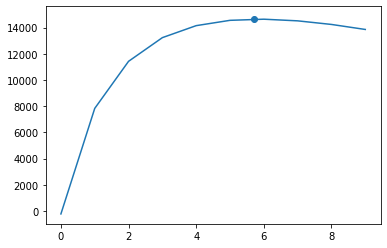

In [5]:
# test 
Tt = 1         # h
r = 5e3       # g/h

Tp = np.array( [ i for i in range(0, 10)] )         # h



Rnet = -(1/2 * r * Cp * Tp**2 + (m*Cp + r*Tt*Ct - r*c) * Tp + 2*Tt*m*Ct) / (2*Tt + Tp)
Tp_star = 2 * (np.sqrt(-Tt/r/Cp * (Tt * r * (Cp - Ct) - m * (Cp - Ct) - r*c)) - Tt)


plt.plot(Tp, Rnet)
plt.scatter(Tp_star, np.max(Rnet))

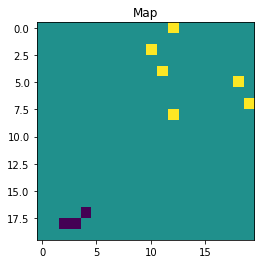

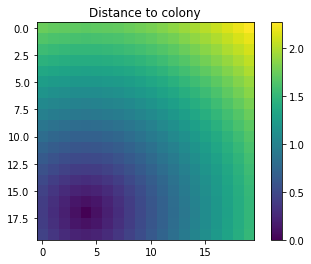

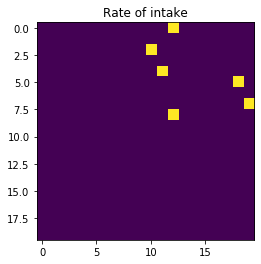

In [6]:
# Map
plt.imshow(np.array(game.map.tileMap));
plt.title('Map')
plt.show()

# Tt
LON = [[game.map.gridLon[i] - birdStart[0] for i in range(game.map.gridSize[0])] for j in range(game.map.gridSize[1])]
LAT = [[game.map.gridLat[j] - birdStart[1] for i in range(game.map.gridSize[0])] for j in range(game.map.gridSize[1])]
Tt = np.sqrt(np.array(LON)**2 + np.array(LAT)**2)
Tt = Tt/10
plt.imshow(Tt);
plt.title('Distance to colony')
plt.colorbar()
plt.show()

# r
r = (np.array(game.map.tileMap) == 2) * 5e3  #g/h
plt.imshow(r);
plt.title('Rate of intake')
plt.show()


/home/amdroy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/amdroy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


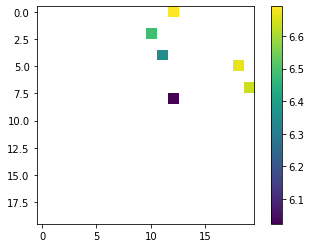

In [7]:
Tp = 2 * (np.sqrt(-Tt/r/Cp * (Tt * r * (Cp - Ct) - m * (Cp - Ct) - r*c)) - Tt)

plt.imshow(Tp);
plt.colorbar()
plt.show()

## Stochastic dynamic programming

A dynamic, state-variable approach to the analysis of behavioural decisions has been proposed through Markov decision process: **state-dependent decision problems**

**Markov decision processes (MDPs)** are discrete-time versions of optimal control problems and provide a mathematical framework for studying sequential, state-dependent decision problems. In these decision problems, time is broken up into discrete steps and outcomes are partly random and partly under the control of the decision maker. An MDP has four components:
1. States: A set of possible, relevant configurations of a system (~ physiological state of the organism + environment)
2. Actions: A set of actions available to the
agent within its environment (~ organisms decisions)
3. Transition function: A function that probabilistically assigns the next
state based on the current state and chosen action (~ dynamics inbetween agent and environment)
4. Reward function: A function that assigns an immediate reward based
on the current state and chosen action (~ measure of Darwinian fitness)

It provides the means to predict growth, maturation, and behavior as a function of physiological state and environmental conditions. The essence of the method is to work backwards in order to generate state-dependent decisions and then to predict forwards using these decisions and Monte Carlo simulation.

> Let $X_t$ representing the animal energy reserves
> $X_{t+1} = X_t - \alpha + Z_t$ (decrease by daily metabolic expenditure, increase by food consumption)
> Energy reserves are bounded (max capacity and min survival)
> Animal knowe its environment: habitat $H_i$, energetic value of food items $Y_i$, probability of discovering food item $\lambda_i$
>
> **Stochastic dynamic programming equation:**
> $J(x, t, T)$ is the *maximal* probability of survival from day $t$ to $T$
> $J(x, t, T) = \max(P_i(x,t,T))  , x >0$
> where $P_i(x,t,T) = (1-\lambda_i) J(x-\alpha, t+1, T) + \lambda_i J(x-\alpha + Y_i, t+1, T)$
>
> If the values of the model parameters are known, then J can be found by an iterative process called backward induction
>
> **Illustration of backward induction:**
> We fix parameters for habitat and associated properties and for all state x (energy reserve)
> Start at the end: $J(x, T, T) = 1$ and compute $J(x, T-1, T)$ and so on


In [61]:
# nb of habitat
nb = 3

# probability of death due to predation
b1 = 0
b2 = 0.01
b3 = 0.05
b = np.array([b1, b2, b3])

# probability of discovering food items
l1 = 0.4
l2 = 0.6
l3 = 0.8
l = np.array([l1, l2, l3])

# energetic value of food items
Y1 = 2
Y2 = 2
Y3 = 2
Y = np.array([Y1, Y2, Y3])

# daily metabolic expenditure
a = 1 

# energy capacity 0<x<20
cap = 20

In [71]:
# J(x,t,T) :  denote the probability of survival from day t until day T with reserve x

def Jend(x):
    if x>0:
        j = 1
    else:
        j = 0
    return j

    
# Start
J = [Jend(x) for x in range(4)]


# Backward induction
Jfood = np.array([Jend(x-a) for x in range(1,4+1)])

minCap = lambda x: min(x, cap)
x =  map(minCap, x-a+Y)
x = np.array(list(x))
Jnofood = np.array([Jend(x) for x in range(1,4+1)])

P = [0 for k in range(0,4)]
for k in range(0,4):
    P[k] = list(((1-b)*(l*Jnofood[k] + (1-l)*Jfood[k])))

P

[[0.4, 0.594, 0.76], [1.0, 0.99, 0.95], [1.0, 0.99, 0.95], [1.0, 0.99, 0.95]]

In [60]:
b

[0, 0.01, 0.05]

In [70]:
P

[[0.4, 0.594, 0.76], [1.0, 0.99, 0.95], [1.0, 0.99, 0.95], [1.0, 0.99, 0.95]]